# Volume-based classification

In [1]:
import glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn.image import resample_img
import os
from scipy.ndimage.morphology import binary_erosion

import seaborn as sbs

import pickle

In [3]:
# Groups
groups=['HCP','CHIASM']

# Participants
CHIASM_con=['CON1','CON2','CON3','CON4','CON5','CON6','CON7','CON8']
CHIASM_alb=['ALB1','ALB2','ALB3','ALB4','ALB5','ALB6','ALB7','ALB8','ALB9']
HCP_con= ['101107','118730','131823','134223','151425','165436','208226','304727','379657','673455']
HCP=HCP_con

# Path to data
data_folder='../../1_Data/'

In [12]:
# Function that takes dictionary and model and returns Sorensen-Dice coefficients for target-prediction pairs

# Dice Similarity Coefficient
def dice(img_true, img_pred, smooth=0):       
    intersection = np.sum(img_true * img_pred)
    union = np.sum(img_true) + np.sum(img_pred)
    dice = (2. * intersection + smooth)/(union+smooth)   
    return dice
                    
def calculate_dice(path1, path2):
    file_target, file_prediction = nib.load(path1), nib.load(path2)   
    file_target_trans, file_prediction_trans = resample_img(file_target, file_prediction.affine, file_prediction.shape, 'linear'),resample_img(file_prediction, file_prediction.affine, file_prediction.shape, 'linear')       
    data_target, data_prediction = file_target_trans.get_fdata(), file_prediction_trans.get_fdata()
    return dice(data_target, data_prediction)

In [13]:
# DSC for X-mask_manual vs X-mask_CNN
dice_hand_refi_vs_pred={}

for group in ['CHIASM_con','CHIASM_alb', 'HCP_con']:
    dice_hand_refi_vs_pred[group]={}
    for sub in eval(group):
        hand=data_folder+'2_X-mask_manual/'+group[:-4]+'/'+sub+'/X-mask_manual.nii.gz'
        pred=data_folder+'5_X-mask_CNN/training_30ep_00025lr_dice/connectivity_3/threshold_1/'+group[:-4]+'/'+sub+'/X-mask_CNN_cropped_to_gt.nii.gz'    
        dice_hand_refi_vs_pred[group][sub]=calculate_dice(hand,pred)

In [14]:
# DSC for X-mask_manual vs X-mask_atlas-corrected
dice_hand_vs_refined={}

for group in ['CHIASM_con','CHIASM_alb', 'HCP_con']:
    dice_hand_vs_refined[group]={}
    for sub in eval(group):
        hand=data_folder+'2_X-mask_manual/'+group[:-4]+'/'+sub+'/X-mask_manual.nii.gz'
        label=data_folder+'4_X-mask_atlas-corrected/'+group[:-4]+'/'+sub+'/X-mask_atlas-corrected_cropped_to_gt.nii.gz'    
        dice_hand_vs_refined[group][sub]=calculate_dice(hand,label)

In [15]:
# DSC for X-mask_manual vs X-mask_atlas-initial
dice_hand_vs_initial={}

for group in ['CHIASM_con','CHIASM_alb', 'HCP_con']:
    dice_hand_vs_initial[group]={}
    for sub in eval(group):
        hand=data_folder+'2_X-mask_manual/'+group[:-4]+'/'+sub+'/X-mask_manual.nii.gz'
        label=data_folder+'3_X-mask_atlas-initial/'+group[:-4]+'/'+sub+'/X-mask_atlas-initial_cropped_to_gt.nii.gz'    
        dice_hand_vs_initial[group][sub]=calculate_dice(hand,label)

In [16]:
# Dictionary of colors
color_dict={}
color_dict['HCP_con']="#648FFF"
color_dict['CHIASM_alb']='#DC267F'
color_dict['CHIASM_con']='#FFB000'

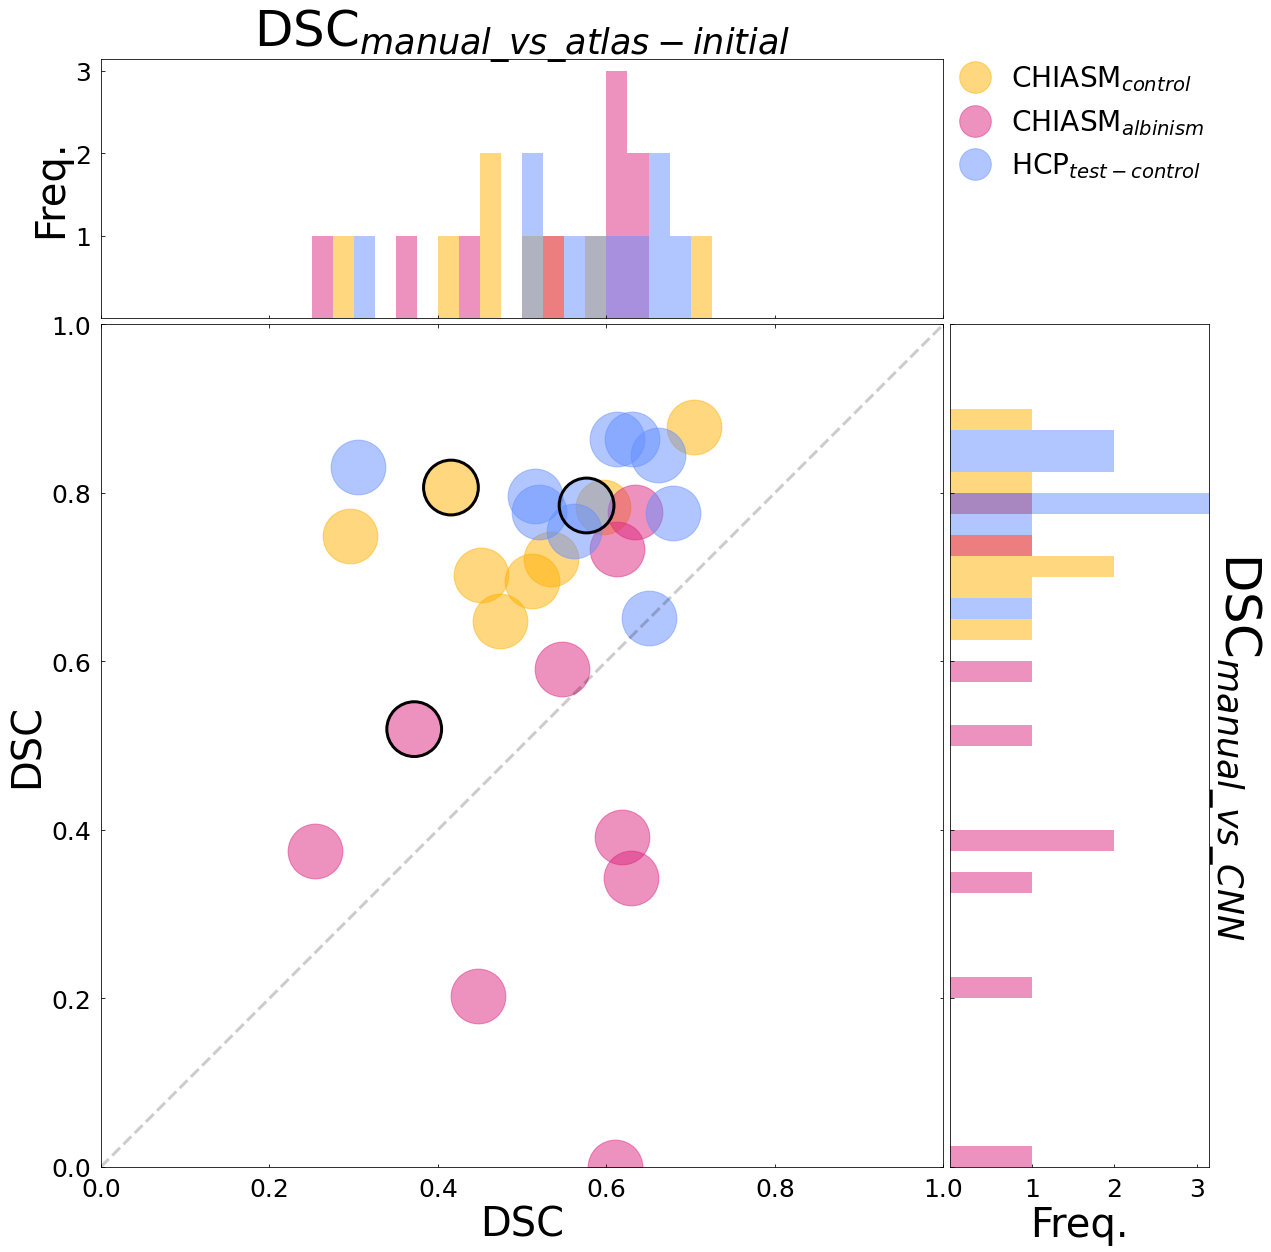

In [17]:
# Plot DICE for HCP
groups=['CHIASM_con','CHIASM_alb','HCP_con']

# Adjusting shape of the figure
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# Rectangular scatter plot settings
plt.figure(figsize=(18, 18))

title_font_size= 50
legend_font_size= 40
axes_font_size= 25

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# Scatter plot:
for g in groups:
    ax_scatter.scatter(list(dice_hand_vs_initial[g].values()),list(dice_hand_refi_vs_pred[g].values()),s=3000,alpha=0.5, label=g, color=color_dict[g])

# Mark chosen datasets
# Default
ax_scatter.scatter(dice_hand_vs_initial['HCP_con']['304727'],dice_hand_refi_vs_pred['HCP_con']['304727'],s=3000, facecolors='none', edgecolors='k', linewidth=3)
ax_scatter.scatter(dice_hand_vs_initial['CHIASM_con']['CON6'],dice_hand_refi_vs_pred['CHIASM_con']['CON6'],s=3000, facecolors='none', edgecolors='k', linewidth=3)
ax_scatter.scatter(dice_hand_vs_initial['CHIASM_alb']['ALB1'],dice_hand_refi_vs_pred['CHIASM_alb']['ALB1'],s=3000, facecolors='none', edgecolors='k', linewidth=3)

lgnd = ax_scatter.legend(['CHIASM$_{control}$','CHIASM$_{albinism}$','HCP$_{test-control}$'],loc='upper right', bbox_to_anchor=(1.34,1.34), fontsize=legend_font_size-12,handlelength=1.0, handleheight=1., framealpha=0)


ax_scatter.plot(np.linspace(0,1),np.linspace(0,1), linestyle='--', color='black', alpha=0.2, linewidth=3)


lgnd.legendHandles[0]._sizes = [1000]
lgnd.legendHandles[1]._sizes = [1000]
lgnd.legendHandles[2]._sizes = [1000]

ax_scatter.tick_params(axis='both', labelsize=axes_font_size, pad=10)

ax_scatter.set_xlabel('DSC', fontsize=legend_font_size)
ax_scatter.set_ylabel('DSC', fontsize=legend_font_size)

# Horizontal and vertical histograms settings
binwidth = 0.025
topval=1
lim = np.ceil(topval / binwidth) * binwidth
ax_scatter.set_xlim((0, lim))
ax_scatter.set_ylim((0, lim))

bins = np.arange(0, lim + binwidth, binwidth)

# Histogram x
for g in groups:
    ax_histx.hist(list(dice_hand_vs_initial[g].values()),bins,alpha=0.5,label=group, color=color_dict[g])  
ax_histx.set_xlim((0,lim))
ax_histx.set_title('DSC$_{manual\_vs\_atlas-initial}$', y=1.03, fontsize=title_font_size)
ax_histx.set_yticks([1,2,3])
ax_histx.tick_params(axis='y', labelsize=axes_font_size, pad=10)
ax_histx.set_ylabel('Freq.', fontsize=legend_font_size)

# Histogram y
for group in groups:
    ax_histy.hist(list(dice_hand_refi_vs_pred[group].values()),bins,alpha=0.5,label=group, orientation='horizontal', color=color_dict[group])  

ax_histy.yaxis.set_label_position("right")
ax_histy.set_ylabel('DSC$_{manual\_vs\_CNN}$', rotation=-90, labelpad=55, fontsize=title_font_size)
ax_histy.set_xlim(ax_histx.get_ylim())
ax_histy.set_ylim(ax_scatter.get_ylim())
ax_histy.set_xticks([1,2,3])
ax_histy.tick_params(axis='x', labelsize=axes_font_size, pad=10)
ax_histy.set_xlabel('Freq.', fontsize=legend_font_size)


#plt.show()
plt.savefig('../../3_Figures/Fig3/Fig3.jpg', format='jpg', dpi=600)

In [18]:
dice_hand_vs_refined['HCP_con']

{'101107': 0.8146453089244852,
 '118730': 0.8492307692307692,
 '131823': 0.7368421052631579,
 '134223': 0.7602739726027398,
 '151425': 0.6686390532544378,
 '165436': 0.7692307692307693,
 '208226': 0.8123393316195373,
 '304727': 0.8409703504043127,
 '379657': 0.6258503401360545,
 '673455': 0.5776566757493188}

In [19]:
# Values for initial
print('Initial')
for group in groups:
    print(f"{group} mean {np.mean(list(dice_hand_vs_initial[group].values())):.5f} and std {np.std(list(dice_hand_vs_initial[group].values())):.5f}")

Initial
CHIASM_con mean 0.49794 and std 0.11411
CHIASM_alb mean 0.52505 and std 0.12897
HCP_con mean 0.57144 and std 0.10379


In [20]:
# Values for refined
print('Refined')
for group in groups:
    print(f"{group} mean {np.mean(list(dice_hand_vs_refined[group].values())):.5f} and std {np.std(list(dice_hand_vs_refined[group].values())):.5f}")

Refined
CHIASM_con mean 0.28217 and std 0.09687
CHIASM_alb mean 0.33113 and std 0.11324
HCP_con mean 0.74557 and std 0.08853


In [21]:
# Values for prediction
print('Prediction')
for group in groups:
    print(f"{group} mean {np.mean(list(dice_hand_refi_vs_pred[group].values())):.5f} and std {np.std(list(dice_hand_refi_vs_pred[group].values())):.5f}")

Prediction
CHIASM_con mean 0.74795 and std 0.06805
CHIASM_alb mean 0.43704 and std 0.23435
HCP_con mean 0.79464 and std 0.06010


In [22]:
# Testing refined and prediction for HCP
print(f"ALB vs HCP t-test equal {ttest_ind(list(dice_hand_vs_refined['HCP_con'].values()),list(dice_hand_refi_vs_pred['HCP_con'].values()))}")


ALB vs HCP t-test equal Ttest_indResult(statistic=-1.37575372445721, pvalue=0.18577671131830137)


In [23]:
# Testing refined and prediction for CHIASM controls
print(f"ALB vs HCP t-test equal {ttest_ind(list(dice_hand_vs_refined['CHIASM_con'].values()),list(dice_hand_refi_vs_pred['CHIASM_con'].values()))}")


ALB vs HCP t-test equal Ttest_indResult(statistic=-10.409273191779103, pvalue=5.6710212150268804e-08)


In [24]:
# Testing refined and prediction for CHIASM controls
print(f"ALB vs HCP t-test equal {ttest_ind(list(dice_hand_vs_refined['CHIASM_alb'].values()),list(dice_hand_refi_vs_pred['CHIASM_alb'].values()))}")


ALB vs HCP t-test equal Ttest_indResult(statistic=-1.1509664226429177, pvalue=0.26665686634201213)


In [25]:
# Testing refined and prediction for CHIASM controls
print(f"ALB vs HCP t-test equal {ttest_ind(list(dice_hand_refi_vs_pred['HCP_con'].values()),list(dice_hand_refi_vs_pred['CHIASM_con'].values()))}")


ALB vs HCP t-test equal Ttest_indResult(statistic=1.455538883800932, pvalue=0.16486050363710597)


In [26]:
# Testing refined and prediction for CHIASM controls
print(f"ALB vs HCP t-test equal {ttest_ind(list(dice_hand_refi_vs_pred['HCP_con'].values()),list(dice_hand_refi_vs_pred['CHIASM_alb'].values()))}")


ALB vs HCP t-test equal Ttest_indResult(statistic=4.406261627682274, pvalue=0.0003859639434391207)


In [27]:
# Testing refined and prediction for CHIASM controls
print(f"ALB vs HCP t-test equal {ttest_ind(list(dice_hand_refi_vs_pred['CHIASM_con'].values()),list(dice_hand_refi_vs_pred['CHIASM_alb'].values()))}")


ALB vs HCP t-test equal Ttest_indResult(statistic=3.3997323313452252, pvalue=0.003959957457813841)


In [31]:
# Perform linear regression on the CHIASM DSC scores
label_control = [1]*len(HCP_con)
label_albinism= [0]*len(CHIASM_alb)

labels = label_control+label_albinism
data_vol=list(dice_hand_refi_vs_pred['HCP_con'].values())+list(dice_hand_refi_vs_pred['CHIASM_alb'].values())

from sklearn.svm import SVC
classifier = SVC(kernel='poly', random_state=0, probability=True)

X_train = np.array(data_vol).reshape(-1,1)
y_train = np.array(labels).reshape(-1,1)

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_train)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
cm = confusion_matrix(y_train, y_pred)
print(cm)

# Print metrics
tn, fp, fn, tp = cm.ravel()

print(f"AUROC: {roc_auc_score(y_train, y_pred)}")
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"Precision: {precision_score(y_train, y_pred)}")
print(f"Recall: {recall_score(y_train, y_pred)}")
print(f"Specificity: {(tn)/(tn+fp)}")


[[7 2]
 [1 9]]
AUROC: 0.8388888888888888
Accuracy: 0.8421052631578947
Precision: 0.8181818181818182
Recall: 0.9
Specificity: 0.7777777777777778


/home/rjp/Software/anaconda3/envs/optic_chiasm/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [32]:
cm

array([[7, 2],
       [1, 9]])

In [33]:
np.max(X_set) + 1

454.0

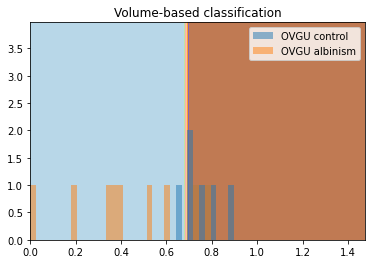

In [34]:
X_set = X_train

#Meshgrid for Contour Plot
x_min, x_max = 0, 1.5
y_min, y_max = 0, 4
h1, h2 = 0.025, 0.025  # step size in the mesh    

xx, yy = np.meshgrid(np.arange(x_min, x_max, h1), np.arange(y_min, y_max, h2))

# Draw Contour Plot
Z = classifier.predict(np.c_[xx.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)



bins = np.linspace(0,1,40)
plt.hist(list(dice_hand_refi_vs_pred['CHIASM_con'].values()), bins, alpha=0.5,label='OVGU control', density=False)
plt.hist(list(dice_hand_refi_vs_pred['CHIASM_alb'].values()), bins, alpha=0.5,label='OVGU albinism', density=False)
plt.title('Volume-based classification')
#plt.hist(hcp_vol, bins, alpha = 0.5, label='hcp', density=True)
plt.legend(loc='upper right')
plt.show()
